In [1]:
%matplotlib notebook

This script plots the experimental data of the different ramps together with the model predictions for Figure 5 and SI.

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import io as sio
from pathlib import Path
import math
import os

C:\Users\tadres\Miniconda3\envs\depol_block_publication\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#root_path_sim = Path('G:/Shared drives/LouisLab COLLABORATIVE Vanishing Spikes/Simulations/Figures/FINAL_SIMULATION')
root_path_sim = Path('G:\\My Drive\\PhD\\Papers\\Vanishing spikes\\all_data\\OSN_simulations')
#path_exp_data = Path('G:/Shared drives/LouisLab COLLABORATIVE Vanishing Spikes/ephys')
path_exp_data = Path('G:\\My Drive\\PhD\\Papers\\Vanishing spikes\\all_data\ephys')
# In order for Matthieu to run this script, I will save the plots directly on the shared folder
save_path = 'Declare Path'


aq_rate = 10000 # All ephys recordings were done at 10 kHz

sim_rate = 1000 # To be checked by Philip! This seems to be the format the spikes themselves are
# Interestingly, the odor stimulus still comes with aq_rate 
sim_rate_PSTH = 10 # It seems Philips PSTH is calculated at 100 ms intervals which is slightly different to mine at 
# 33ms

In [4]:
font_size = 18
plt.rcParams['svg.fonttype'] = 'none'
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : font_size,
    'style'  : 'normal'}

plt.rc('font', **font)

# PLOTTING STARTS

In [9]:
    
def plot(sim_data, 
         exp_data,
         savename,
         xlim=(6,16),
         remove_from_sim=0,
         transduction_current = False,
         transduction_current_color = 'k',
         psth_ylim=None,conc_ylim=None,scale_ylim=None,ticks_ax1=None,ticks_ax2=None):
    """
    I prefer to put code that is re-used into a function to make sure there are not small
    differences between the final code. 
    
    Once something has been modified here, re-run this cell to re-define the function
    before callin the function in the relevant cell (e.g. exponential)
    """
    
    figsize = (5,5) # Change the numbers here to modify x/y size of the plot
    color_data = 'k' # see here to see available colors:
    # https://matplotlib.org/stable/gallery/color/named_colors.html
    color_sim = 'blue'
    
    odor_stim_line_thickness = 2
    rasterplot_line_thickness = 0.1
    alpha_PSTH = 0.65 #0.5
    
    # Probably no need to change anything below
    time_stim = sim_data['stim'][0][0]['t']
    stim = np.roll(sim_data['stim'][0][0]['x'], - (remove_from_sim*aq_rate))

    fig = plt.figure(figsize=figsize)

    # Start plotting the stimulus
    # See here for an explanation of '411' and how it relates to the internal geometry of the figure:
    # https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111
    ax1 = fig.add_subplot(411)
    ax1.plot(time_stim, stim, color = 'gold', lw=odor_stim_line_thickness) # see here to see available colors:
    # https://matplotlib.org/stable/gallery/color/named_colors.html
    ax1.set_ylabel('Concentration [μM]')
#     ax1.set_ylabel('Concentration [$\si{\micro}$M]') 
    
    # if transduction current is plotted, DO NOT plot experimental data
    # I coded this in this form to be as explicit as possible for human reader.
    if not transduction_current:
        # First, plot the REAL data
        ax2 = fig.add_subplot(412, sharex=ax1)
        counter = 0
        for current_column in exp_data:
            if 'spikes' in current_column:
                ax2.eventplot(np.where(exp_data[current_column] == 1)[0] / aq_rate,
                             linewidth=rasterplot_line_thickness, lineoffsets=counter, color=color_data)
                counter += 1
    if transduction_current:
        ax2 = fig.add_subplot(412, sharex=ax1)
        time_transduction_current = sim_data['sim'][0][0]['It'][0][0]/ sim_rate
        sim_transduction_current = sim_data['sim'][0][0]['I'][0][0]
        
        transduction_sim_rate = 1/time_transduction_current[1] # This seems to be 50 Hz?
        ax2.plot(time_transduction_current,
                 np.roll(sim_transduction_current, - int((remove_from_sim * transduction_sim_rate.round()))), 
                color=transduction_current_color)


    # Then plot the simulated data
    sim_spike_times = sim_data['sim'][0][0]['spike_times']

    ax3 = fig.add_subplot(413, sharex=ax1)
    for current_trial in range(sim_spike_times.shape[0]):
        ax3.eventplot(sim_spike_times[current_trial][0]/sim_rate - remove_from_sim,
                         linewidth=rasterplot_line_thickness, lineoffsets=current_trial, color=color_sim)

    # Finally, plot PSTH
    time_sim_PSTH = sim_data['sim'][0][0]['yt'].T
    sim_PSTH = sim_data['sim'][0][0]['y']
    
    time_sim_PSTH = time_sim_PSTH - xlim[0] #Philip
    exp_data['Time [s]'] = exp_data['Time [s]'] - xlim[0] #Philip
    
    ax4 = fig.add_subplot(414)
    ax4.plot(time_sim_PSTH, 
             np.roll(sim_PSTH, -(remove_from_sim*sim_rate_PSTH))
             , c=color_sim, label='Simulation', alpha=alpha_PSTH, lw = 2)
    ax4.plot(exp_data['Time [s]'], exp_data['PSTH [Hz]'], color=color_data, label='Data', alpha=alpha_PSTH, lw = 2)
    ax4.set_ylabel('Firing rate [Hz]')
    ax4.set_xlabel('Time [s]')
    
    # If user provides a ylim range for the PSTH it is applied here
    if psth_ylim is not None:
        ax4.set_ylim(psth_ylim)
    if conc_ylim is not None:
        ax1.set_ylim(conc_ylim)
    if scale_ylim is not None:
        ax1.set_yscale('symlog')
        ax1.yaxis.set_ticks([0,10,100])
    if ticks_ax1 is not None:
        ax1.yaxis.set_ticks(ticks_ax1)
    if ticks_ax2 is not None:
        ax2.yaxis.set_ticks(ticks_ax2)

    # Can be used to change x range
    ax1.set_xlim(xlim)
    # Analog for y, it would be called ax1.set_ylim(0,1.5)
    # Note that all other subplots(ax2, ax3 and ax4) are tied to ax1 therefore it is sufficent to just change ax1
    # To change xlim independently for each subplot remove the 'sharex=ax1' when e.g. ax2 is created.
    
    #Philip's Edits
    ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
    ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
    ax3.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
    
    ax3.tick_params(axis='y',which='both',left=False,labelleft=False) 
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    
    ax3.axis("off")
    
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    
    if transduction_current:
        ax2.set_ylabel('I [μA/cm²]')
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.set_ylim([0,5])    
        ax2.yaxis.set_ticks([0,2,4]) 
        
        ax1.yaxis.set_label_coords(-0.1,0.7)        
        ax2.yaxis.set_label_coords(-0.1,0.1)
    else:
        ax2.axis("off")
        ax2.tick_params(axis='y',which='both',left=False,labelleft=False)
           
    if (xlim[1] > 60):
        ax4.xaxis.set_ticks(np.arange(0,xlim[1]-xlim[0],round((xlim[1] - xlim[0])/40))*10)
        ax4.set_xlim([0,xlim[1]-xlim[0]])        
    elif (xlim[1] < 20):
        ax4.xaxis.set_ticks([0,5,10])
        ax4.set_xlim([0,xlim[1]-xlim[0]])        
    elif (xlim[1] < 40):
        ax4.xaxis.set_ticks([0,10,20,30])
        ax4.set_xlim([0,xlim[1]-xlim[0]])      
        
    ax1.tick_params(axis="x", labelsize=font_size)
    ax1.tick_params(axis="y", labelsize=font_size)
    ax2.tick_params(axis="x", labelsize=font_size)
    ax2.tick_params(axis="y", labelsize=font_size)
    ax4.tick_params(axis="x", labelsize=font_size)
    ax4.tick_params(axis="y", labelsize=font_size)
    
    #fig.savefig(Path(save_path, savename),bbox_inches='tight') # Uncomment to save figure
    
    savename_pdf = os.path.splitext(savename)[0]+'.pdf'
    #fig.savefig(Path(save_path, savename_pdf),bbox_inches='tight') # Uncomment to save figure

### Exponential ramp

<IPython.core.display.Javascript object>


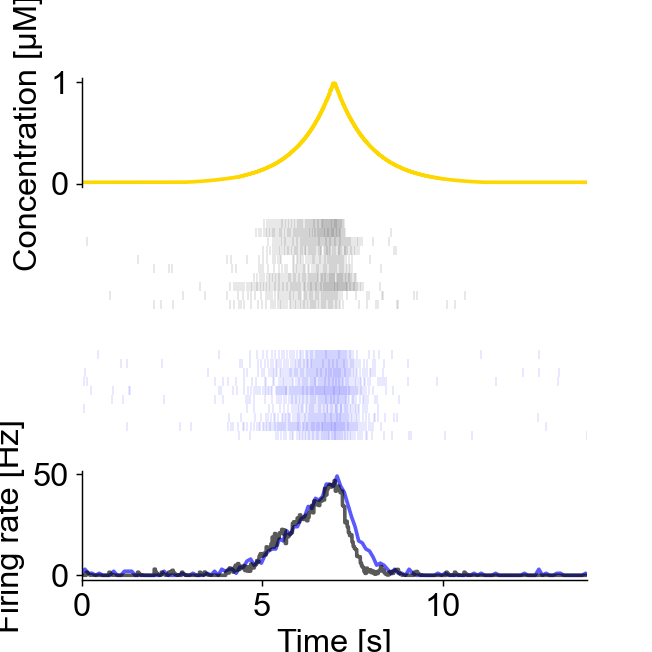

In [10]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM exponential.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\exponential/EtB 1uM exponential').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5C_exponential_raster_sim.svg', xlim=(4,18))

### Sigmoid ramp

<IPython.core.display.Javascript object>


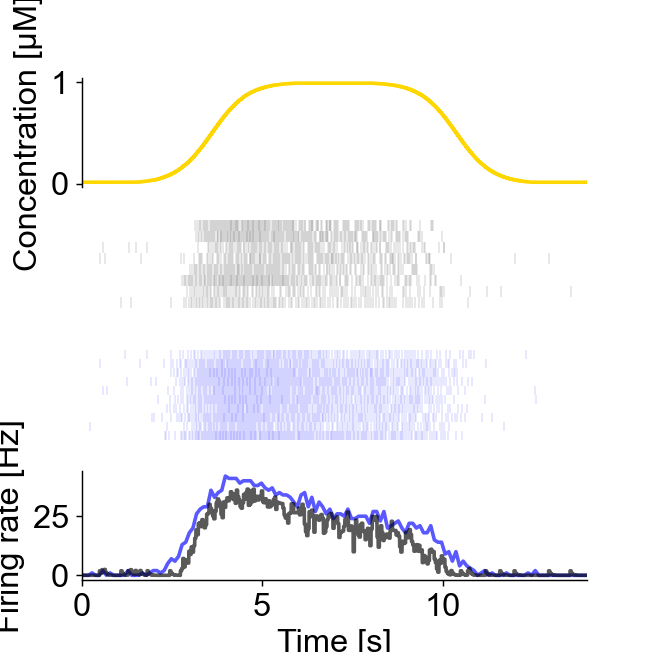

In [11]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM sigmoid.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB/sigmoid/EtB 1uM sigmoid').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5C_sigmoid_raster_sim.svg', xlim=(4,18))

### 10 s ramp

<IPython.core.display.Javascript object>


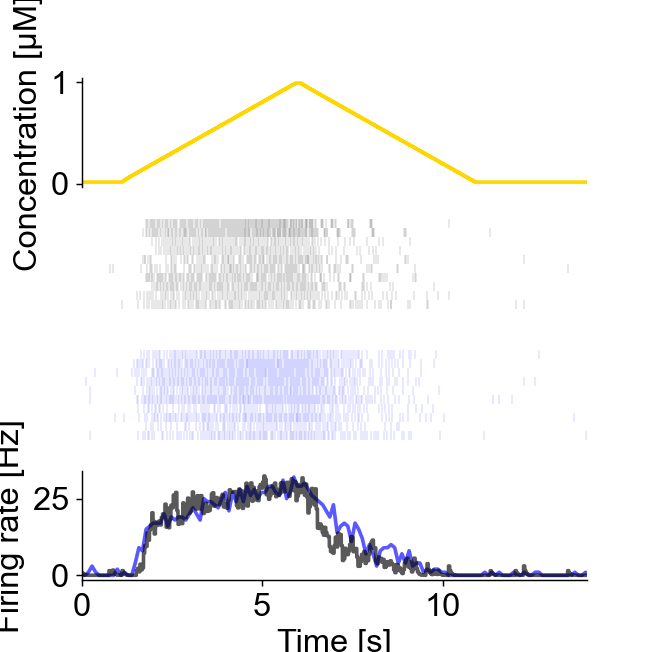

In [12]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM ramp 10s.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB/ramp 10s/EtB 1uM ramp 10s').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5C_10s_ramp_raster_sim.svg', xlim=(4,18))   

### 1s gap

<IPython.core.display.Javascript object>


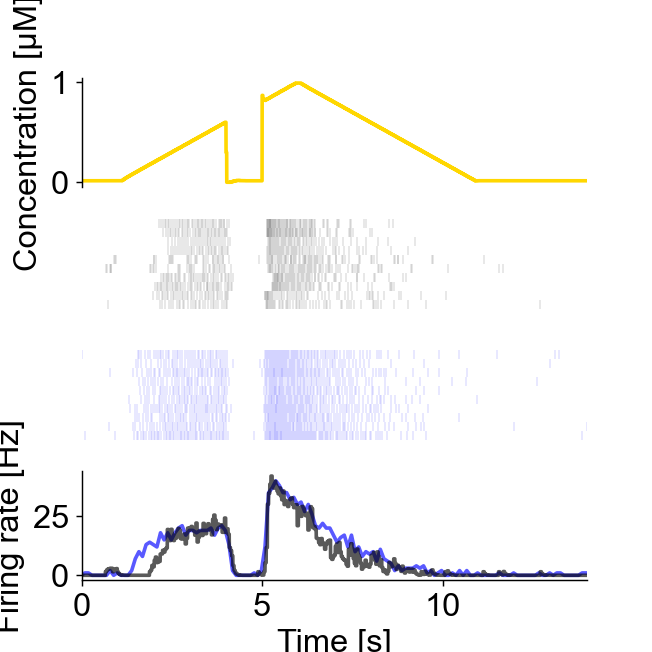

In [13]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM gap 1s.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB/gap 1s/EtB 1uM gap 1s').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5_1s_gap_raster_sim.svg', xlim=(4,18))   

### 1s pulse

In [14]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM pulse 1s.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB/pulse 1s/EtB 1uM pulse 1s').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5_1s_pulse_raster_sim.svg' , xlim=(4,18))   

<IPython.core.display.Javascript object>

# Step functions

### 0.5nM step function

<IPython.core.display.Javascript object>


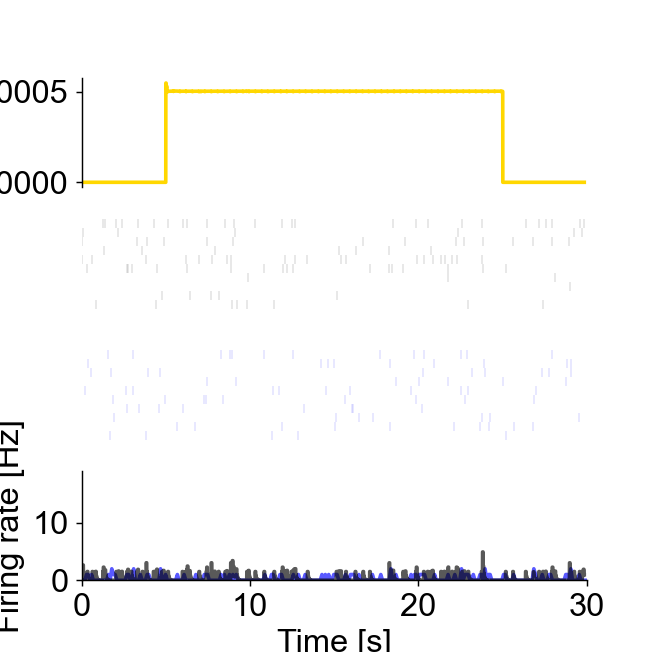

In [15]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 500pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 500pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_500pM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,19))

### 1 nM step function

<IPython.core.display.Javascript object>


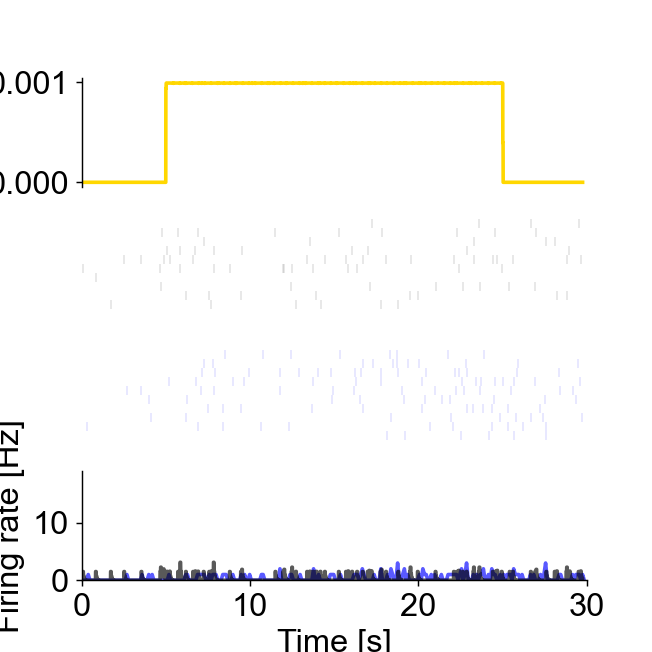

In [16]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 1000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_1nM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,19))

### 5 nM step function

<IPython.core.display.Javascript object>


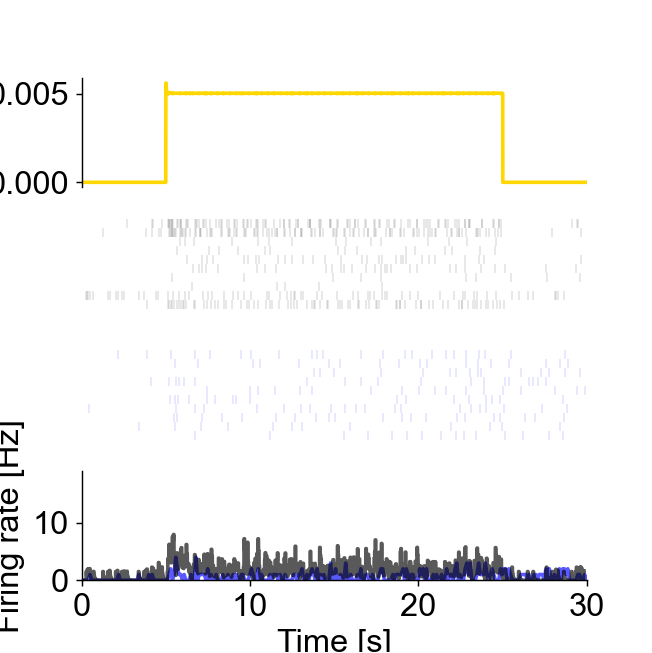

In [17]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 5000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 5000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_5nM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,19))

### 10 nM step function

<IPython.core.display.Javascript object>


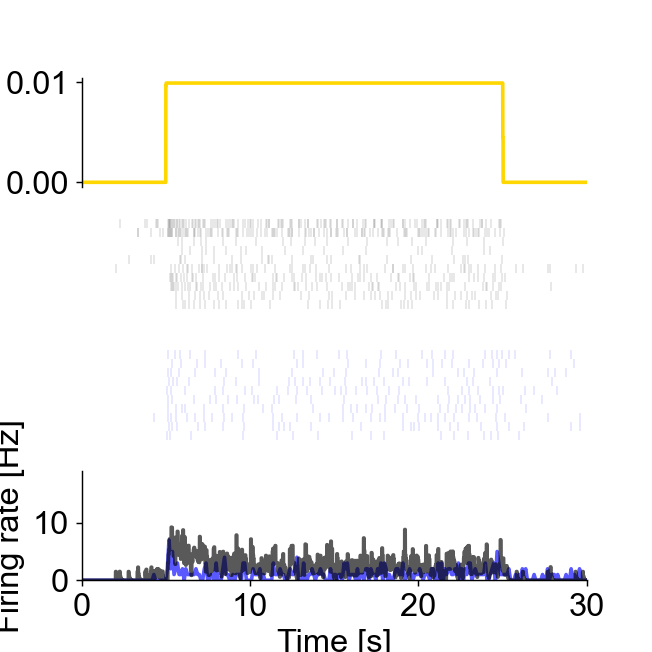

In [18]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 10000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 10000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_10nM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,19))

### 50 nM step function

<IPython.core.display.Javascript object>


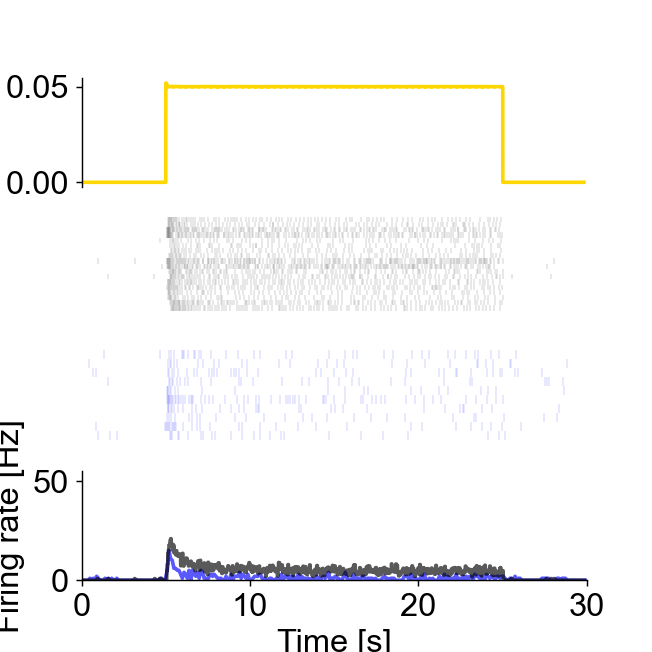

In [20]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 50000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 50000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_50nM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,55))

### 100 nM step function

<IPython.core.display.Javascript object>


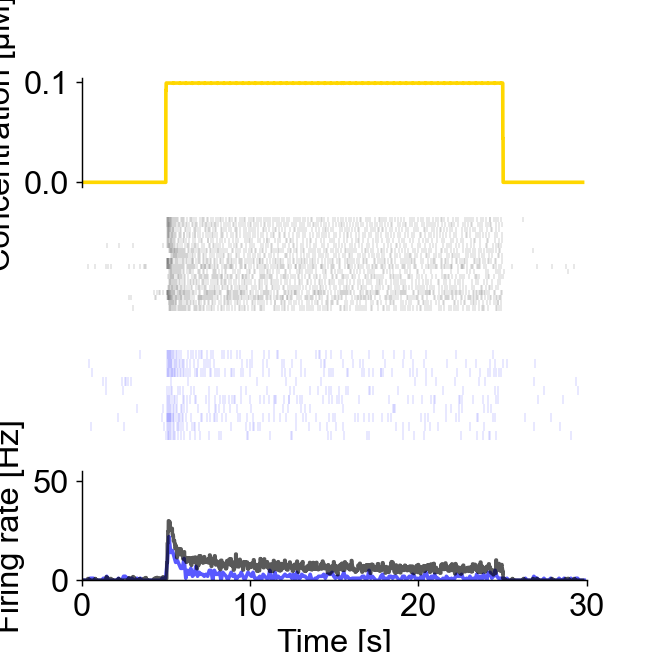

In [21]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 100000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 100000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3B_100nM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,55))

### 500 nM step function

In [22]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 500000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 500000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_500nM_step_raster_sim.svg',xlim=(0,30),psth_ylim=(0,55))

<IPython.core.display.Javascript object>

### 1 uM step function

In [23]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1000000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 1000000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5D_1uM_step_raster_sim.svg',xlim=(0,30))

<IPython.core.display.Javascript object>

### 5 uM step function

This is probably a very important condition!

<IPython.core.display.Javascript object>


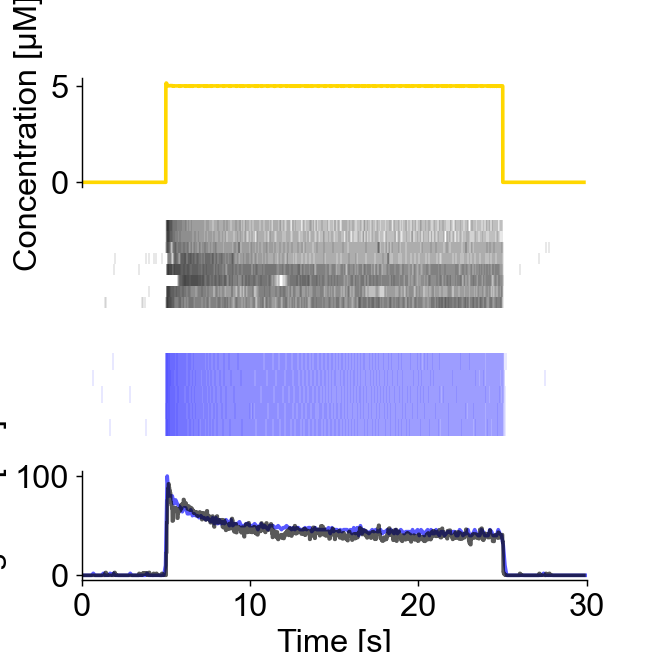

In [24]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 5000000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 5000000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_5uM_step_raster_sim.svg',xlim=(0,30))

# 10 uM step function

In [25]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 10000000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 10000000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig5D_10uM_step_raster_sim.svg',xlim=(0,30))

<IPython.core.display.Javascript object>

# 100 uM step function

<IPython.core.display.Javascript object>


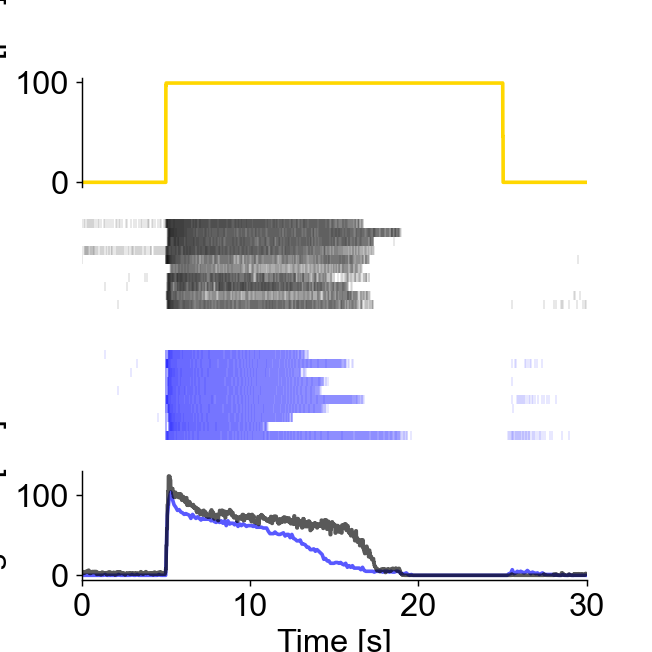

In [26]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 100000000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 100000000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3C_100uM_step_raster_sim.svg',xlim=(0,30))

# 1000 uM step function

<IPython.core.display.Javascript object>


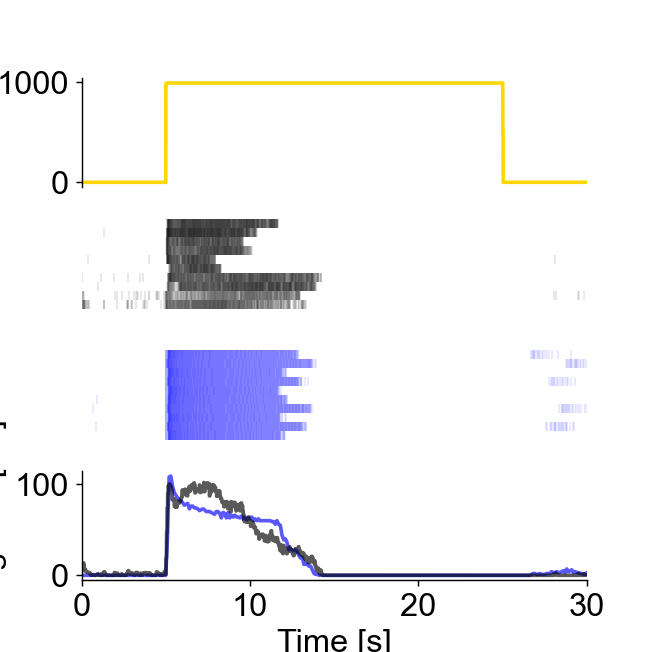

In [28]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1000000000pM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\step stim\\EtB 1000000000pM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'FigSI3B_1000uM_step_raster_sim.svg',xlim=(0,30))

# Hysteresis

### 100 uM ramp


In [29]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_long_ramp_100uM.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\Hysteresis\\long_ramp_100uM').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'Fig5H_100uM_long_ramp.svg',xlim=(0,90), remove_from_sim=remove_from_sim)

<IPython.core.display.Javascript object>

### Sigmoid

In [31]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_sigmoid.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\Hysteresis\\sigmoid').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4C_sigmoid.svg',xlim=(0,62.5), remove_from_sim=remove_from_sim, scale_ylim = 1,conc_ylim = (0,100))

<IPython.core.display.Javascript object>

### Sigmoid break

<IPython.core.display.Javascript object>


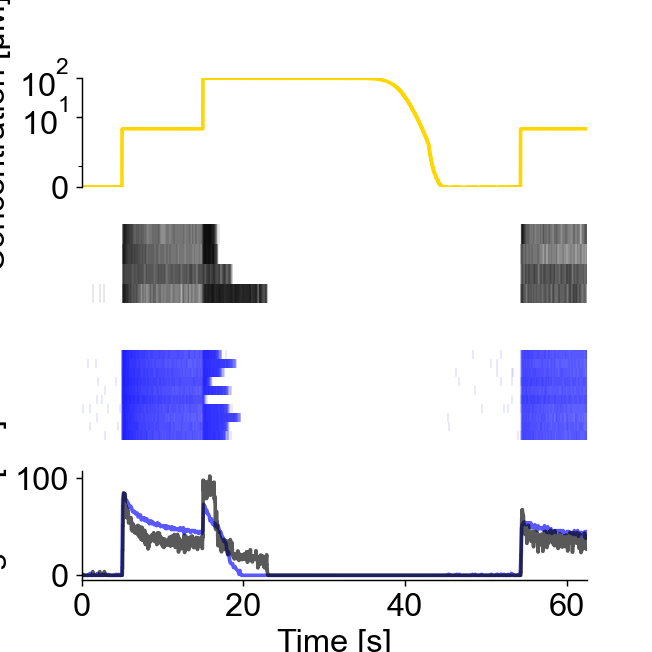

In [33]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_sigmoid_break.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\Hysteresis\\sigmoid_break').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4C_sigmoid_break.svg',xlim=(0,62.5), remove_from_sim=remove_from_sim,scale_ylim = 1,conc_ylim = (1,100))

# Trajectories

### 50 mM trajectory

C:\Users\tadres\AppData\Local\Temp\ipykernel_8416\1680354661.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


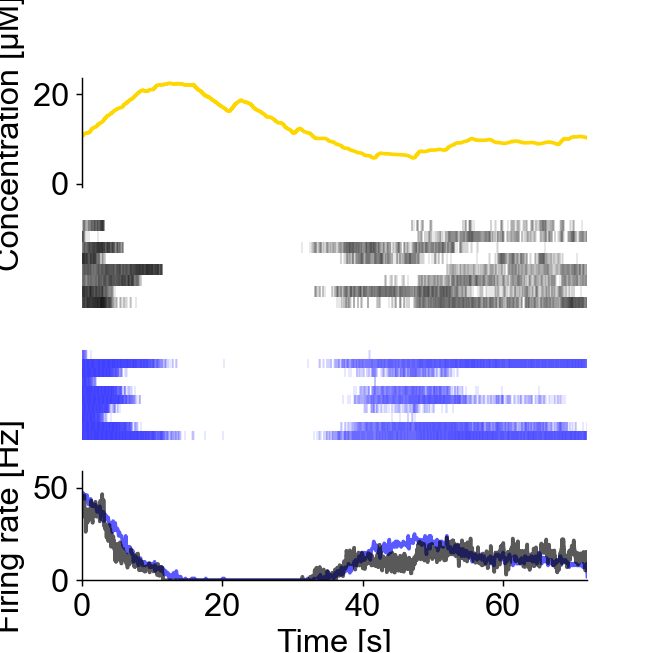

In [34]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_50mM_trajectory.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\trajectories\\50mM_trajectory').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4B_50mM_trajectory.svg',xlim=(18,89.9), remove_from_sim=remove_from_sim,psth_ylim = (0,59))

## 1 mM trajectory

Philip used Or42bSF EtB_1mM_trajectory1 (10 to 40s) for fitting. Plot this here.

Note: Philip shifted everything by 10 seconds so it really is 0 - 30 seconds.

<IPython.core.display.Javascript object>


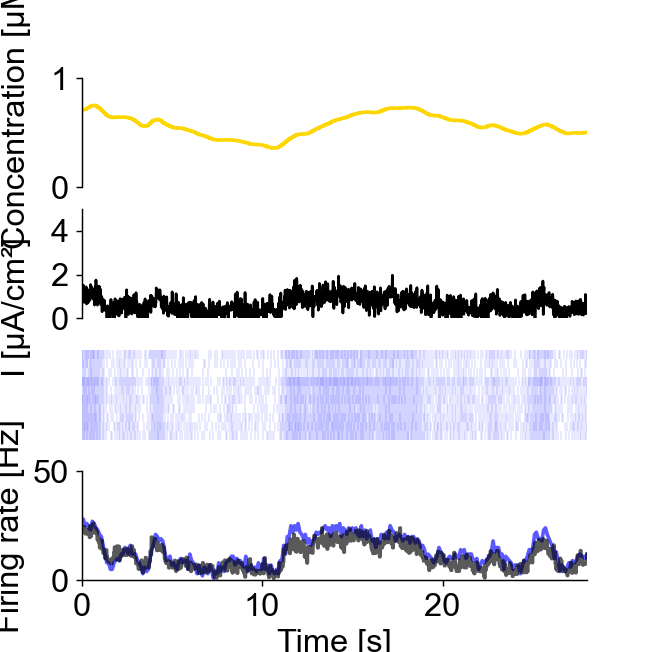

In [35]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_1mM_trajectory1.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\trajectories\\1mM_trajectory1').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4A_1mM_trajectory1used_for_fitting.svg',xlim=(2,30), 
     transduction_current=True, remove_from_sim=remove_from_sim,psth_ylim = (0,50),conc_ylim = (0,1),ticks_ax1 = (0,1))     

<IPython.core.display.Javascript object>


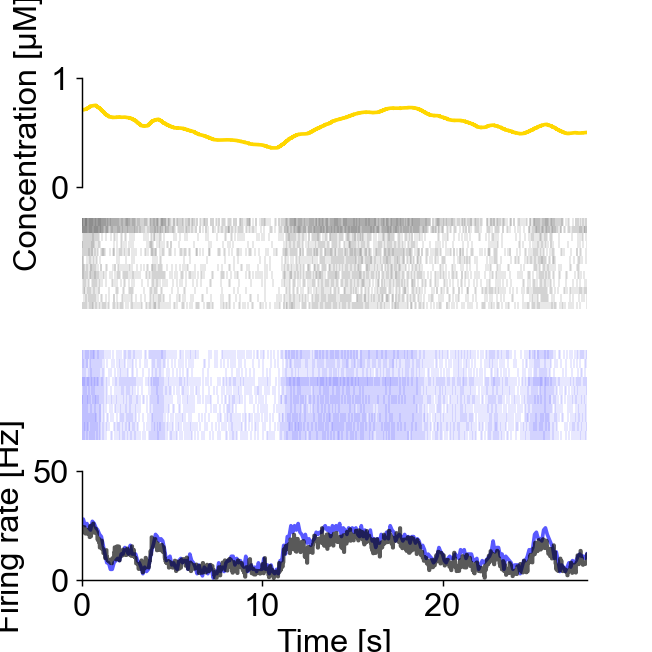

In [36]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_1mM_trajectory1.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\trajectories\\1mM_trajectory1').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4A_1mM_trajectory1used_for_fitting_raster.svg',xlim=(2,30), remove_from_sim=remove_from_sim,\
     psth_ylim = (0,50),conc_ylim = (0,1),ticks_ax1 = (0,1))  

### 1 mM Trajectory #1

In [37]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_1mM_trajectory1.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\trajectories\\1mM_trajectory1').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4A_1mM_trajectory1.svg',xlim=(1,89.9), remove_from_sim=remove_from_sim,\
     psth_ylim = (0,50),conc_ylim = (0,1),ticks_ax1 = (0,1))    

<IPython.core.display.Javascript object>

### 1 mM, trajectory #3

<IPython.core.display.Javascript object>


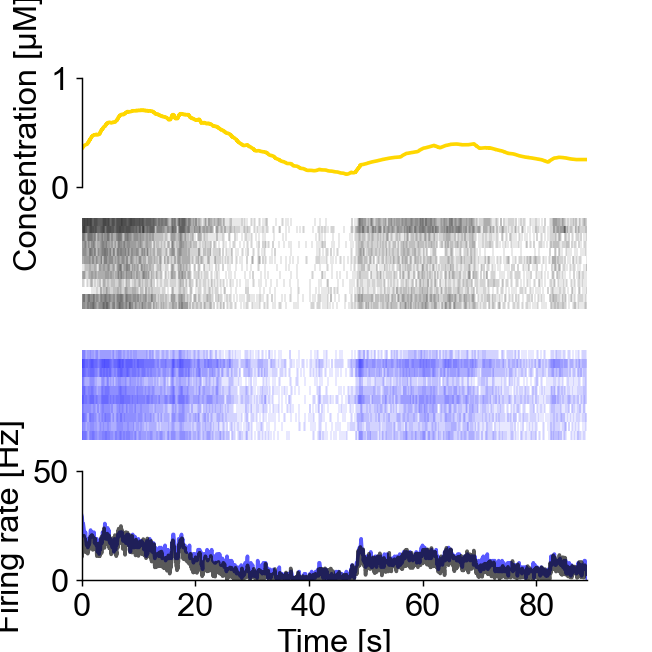

In [38]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_1mM_trajectory3.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\trajectories\\1mM_trajectory3').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4A_1mM_trajectory3.svg',xlim=(1,89.9), remove_from_sim=remove_from_sim,\
     psth_ylim = (0,50),conc_ylim = (0,1),ticks_ax1 = (0,1))       

### 1 mM, trajectory #4

<IPython.core.display.Javascript object>


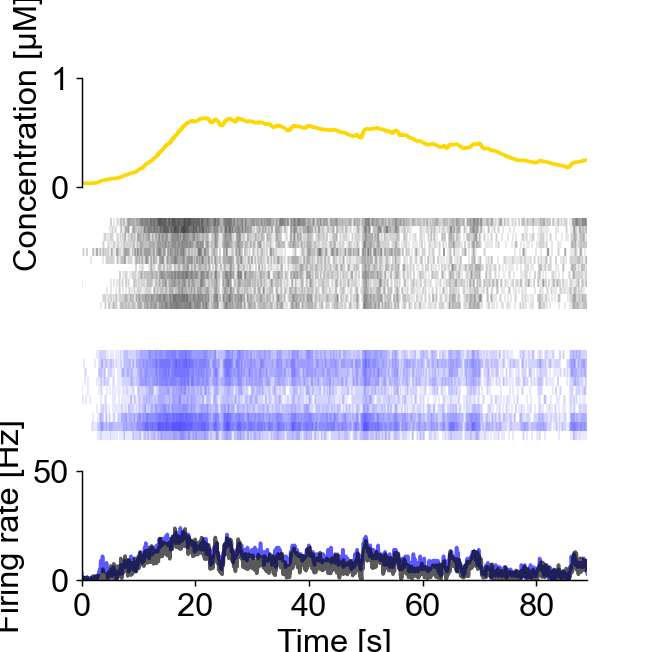

In [39]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_1mM_trajectory4.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\trajectories\\1mM_trajectory4').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

# If the simulation and data obviously don't fit, check with Philip.
# In this example he added 10 seconds at the beginning to add some relaxation
# To account for this (and the fact that this might change in the future) the
# variable below can be used to remove this part
remove_from_sim = 10 # seconds, as per Philips email. Can be set to zero
        
plot(sim_data, exp_data, 'FigSI4A_1mM_trajectory4.svg',xlim=(1,89.9), remove_from_sim=remove_from_sim,\
     psth_ylim = (0,50),conc_ylim = (0,1),ticks_ax1 = (0,1))     

# With transduction current

<IPython.core.display.Javascript object>


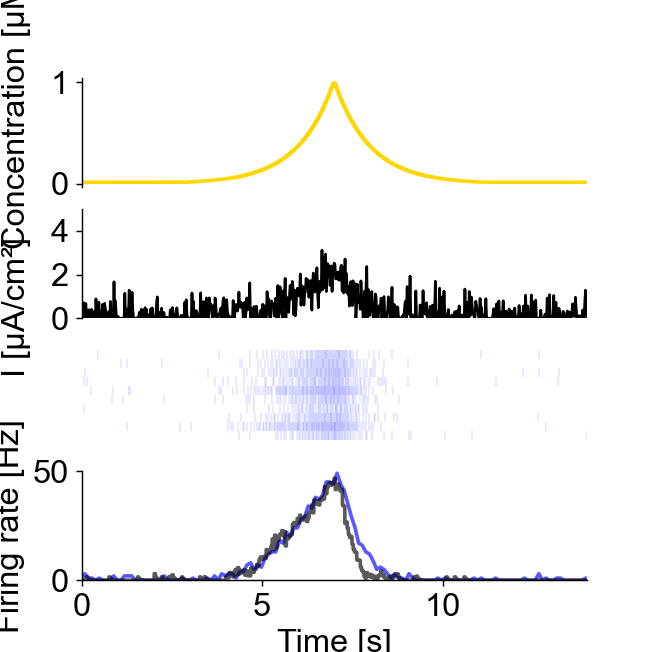

In [40]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM exponential.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\exponential\\EtB 1uM exponential').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig3SI_exponential_transduction.svg',
    transduction_current=True, psth_ylim = (0,50),xlim=(4,18))    #, xlim=(0,30))   

# Sigmoid

<IPython.core.display.Javascript object>


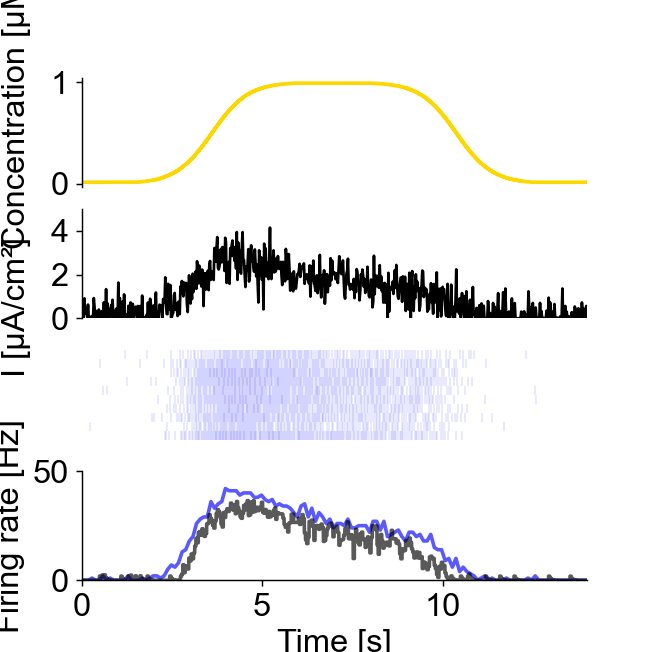

In [41]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM sigmoid.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\sigmoid\\EtB 1uM sigmoid').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig3SI_sigmoid_transduction.svg',
    transduction_current=True , xlim=(4,18), psth_ylim = (0,50))      

# 10 s ramp

<IPython.core.display.Javascript object>


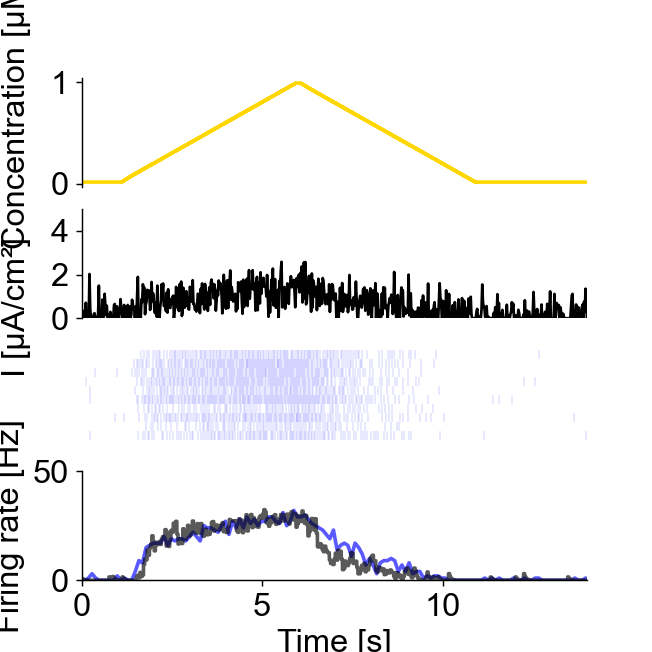

In [42]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM ramp 10s.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\ramp 10s\\EtB 1uM ramp 10s').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig3SI_10s_ramp_transduction.svg',
    transduction_current=True , xlim=(4,18), psth_ylim = (0,50))   

# 1s gap

<IPython.core.display.Javascript object>


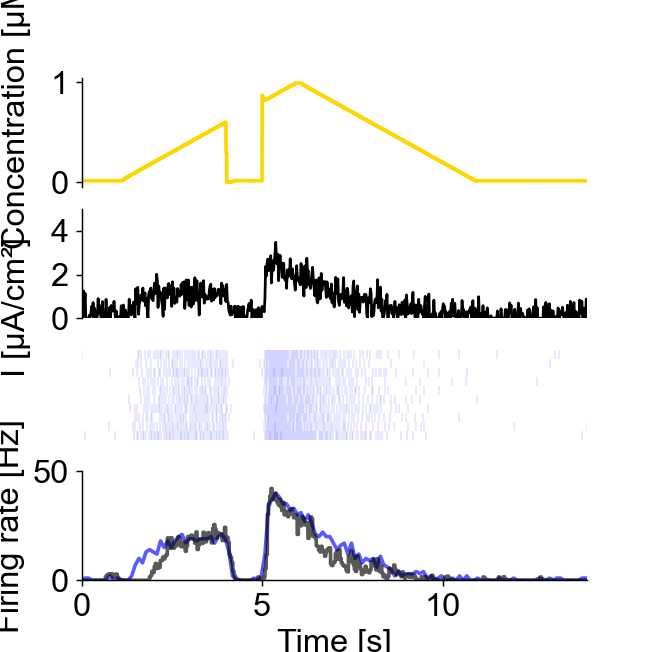

In [43]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM gap 1s.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\gap 1s\\EtB 1uM gap 1s').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig3SI_1s_gap_transduction.svg',
    transduction_current=True , xlim=(4,18), psth_ylim = (0,50))      

# 1s pulse

<IPython.core.display.Javascript object>


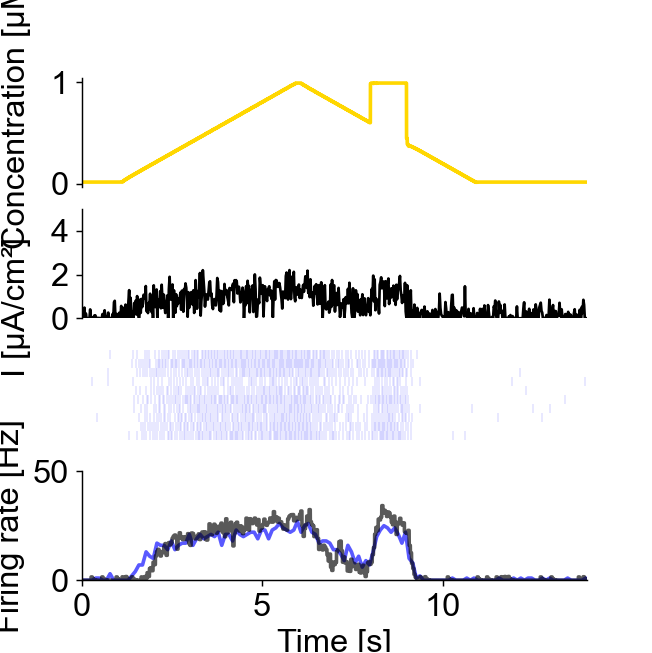

In [44]:
sim_data = sio.loadmat(Path(root_path_sim, 'Or42bSF EtB_EtB 1uM pulse 1s.mat'))

for current_file in Path(path_exp_data, 'Or42bSF EtB\\pulse 1s\\EtB 1uM pulse 1s').iterdir():
    if 'csv' in current_file.name:
        exp_data = pd.read_csv(current_file)

plot(sim_data, exp_data, 'Fig3SI_1s_pulse_transduction.svg',
    transduction_current=True , xlim=(4,18) , psth_ylim = (0,50)) 